In [1]:
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

In [5]:
gc_frame_dict = {'galcen_distance':8*u.kpc, 'z_sun':0*u.pc}
gc_frame = coord.Galactocentric(**gc_frame_dict)
ham = gp.Hamiltonian(gp.LogarithmicPotential(v_c=225*u.km/u.s, r_h=0*u.kpc, q1=1, q2=1, q3=1, units=galactic))

In [33]:
t_impact = -495*u.Myr
t_start = -3*u.Gyr

pert_at_impact = gd.PhaseSpacePosition(
    pos=[-18.198455, 2.7829913, 11.173008]*u.kpc,
    vel=[-51.051972, -216.7645, -113.60831]*u.km/u.s)
pert_orbit = ham.integrate_orbit(pert_at_impact, 
                                 dt=-0.1, t1=t_impact, t2=t_start)
pert_at_start = pert_orbit[-1]

prog_at_start = gd.PhaseSpacePosition(
    pos=[-19.36473268, -7.23486128, 5.02312534]*u.kpc,
    vel=[0.07986908, -0.12925221, -0.12822027]*u.kpc/u.Myr,
    frame=pert_at_start.frame)

In [51]:
prog_pot = gp.HernquistPotential(
    2.5e4*u.Msun, 10*u.pc, units=galactic)

df = gd.FardalStreamDF(lead=True, trail=True)
gen = gd.MockStreamGenerator(df, ham, progenitor_potential=prog_pot)

In [52]:
unperturbed_stream, _ = gen.run(
    prog_w0=prog_at_start,
    prog_mass=prog_pot.parameters['m'], 
    dt=0.1, t1=t_start, t2=0*u.Gyr, 
    n_particles=1, release_every=10)

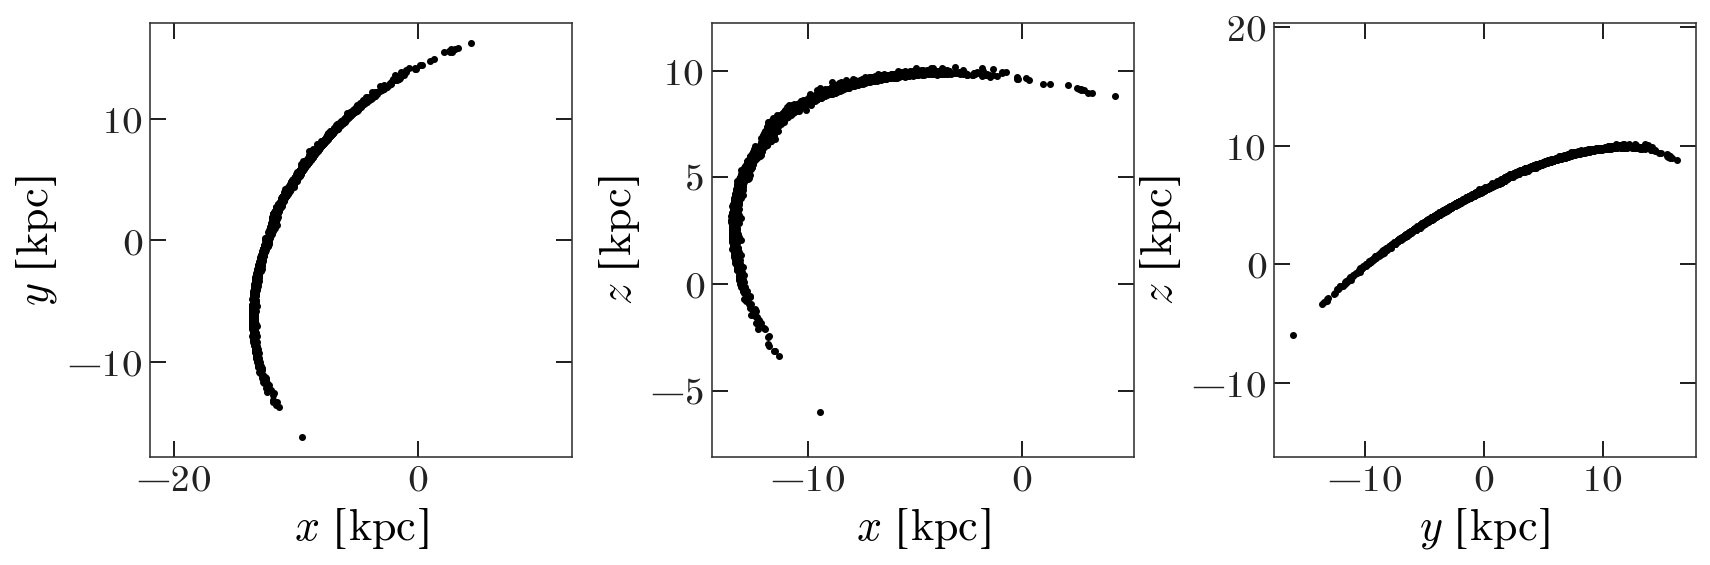

In [53]:
_ = unperturbed_stream.plot()

In [54]:
unperturbed_gd1_c = unperturbed_stream.to_coord_frame(gc.GD1(), 
                                                      galactocentric_frame=gc_frame)

(-10.0, 5.0)

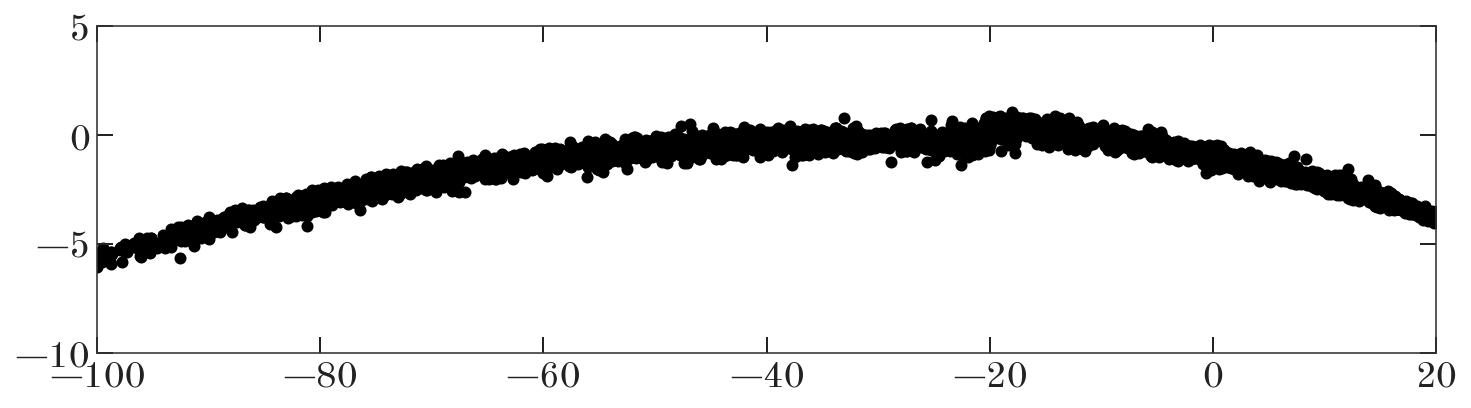

In [55]:
plt.figure(figsize=(12, 3))
plt.scatter(unperturbed_gd1_c.phi1.degree, unperturbed_gd1_c.phi2.degree)
plt.xlim(-100, 20)
plt.ylim(-10, 5)

# Perturb the stream

In [56]:
pert_pot = gp.HernquistPotential(
    5e6*u.Msun, 2*u.pc, units=galactic)

In [60]:
nbody = gd.DirectNBody(pert_at_start, 
                       particle_potentials=[pert_pot], 
                       external_potential=ham.potential,
                       frame=ham.frame)

perturbed_stream, _ = gen.run(
    prog_w0=prog_at_start,
    prog_mass=prog_pot.parameters['m'], 
    nbody=nbody,
    dt=0.1, t1=t_start, t2=0*u.Gyr, 
    n_particles=1, release_every=2,
    output_filename='gd1-perturbed.hdf5',
    output_every=10)

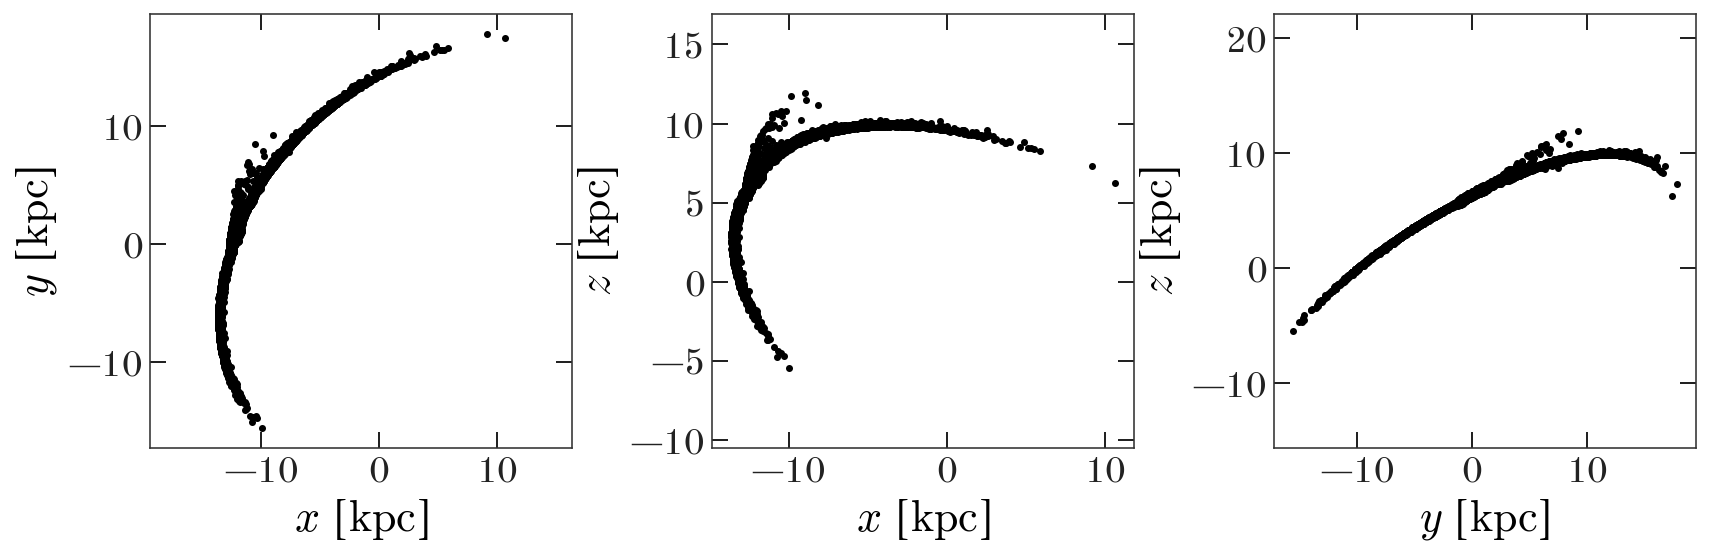

In [61]:
_ = perturbed_stream.plot()

(-10.0, 5.0)

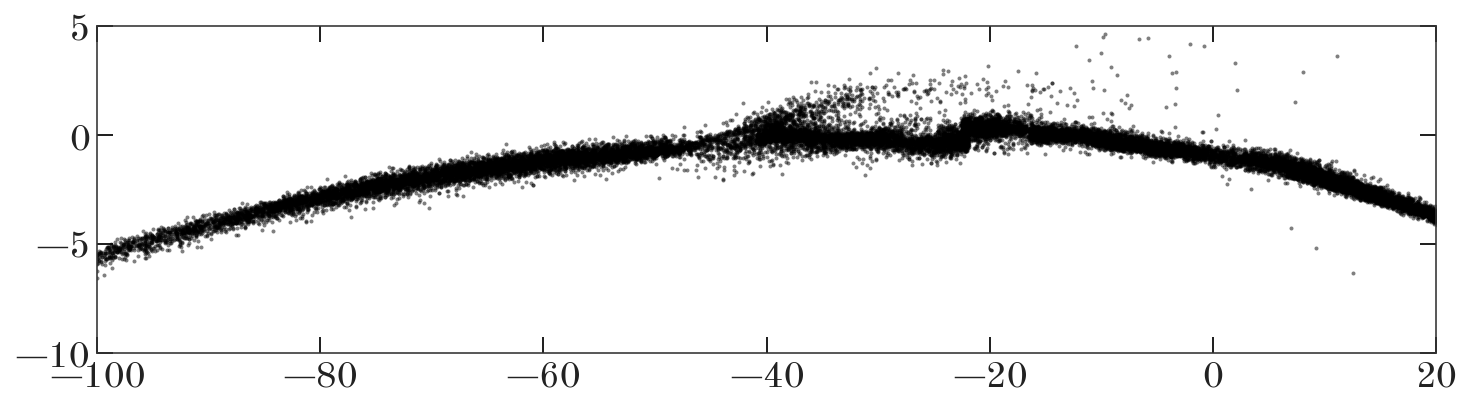

In [62]:
perturbed_gd1_c = perturbed_stream.to_coord_frame(gc.GD1(),
                                                  galactocentric_frame=gc_frame)

plt.figure(figsize=(12, 3))
plt.plot(perturbed_gd1_c.phi1.degree, perturbed_gd1_c.phi2.degree,
         marker='o', mew=0., ls='none', alpha=0.5, ms=2.)
plt.xlim(-100, 20)
plt.ylim(-10, 5)

In [96]:
import h5py
import re
import json

In [90]:
with h5py.File('gd1-perturbed.hdf5', 'r') as f:
#     print(f['nbody/pos'].shape)
#     print(list(f['stream/pos'].keys()))
#     print(list(f['stream/pos'].shape))
    stream_pos = f['stream/pos'][:]
    perturber_pos = f['nbody/pos'][:][..., 1]
    
stream_pos = np.rollaxis(stream_pos[:, ::2].T, axis=1, start=0)
perturber_pos = perturber_pos[:, ::2].T
stream_pos.shape, perturber_pos.shape

((1501, 30002, 3), (1501, 3))

In [91]:
data = {}
data['stream'] = stream_pos.tolist()
data['perturber'] = perturber_pos.tolist()

In [97]:
# https://stackoverflow.com/questions/54370322/how-to-limit-the-number-of-float-digits-jsonencoder-produces
pat = re.compile(r"\d+\.\d{5,}")
def mround(match):
    return "{:.3f}".format(float(match.group()))

with open('../data/gd1-perturbed-orbits.json', 'w') as f:
    dstr = json.dumps(data)
    f.write(re.sub(pat, mround, dstr).replace('NaN', 'null'))

KeyboardInterrupt: 